In [1]:
# !wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db

--2024-10-17 12:25:04--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db.2’

ds-plus-final.db.2  100%[===================>]   3.42M  7.66MB/s    in 0.4s    

2024-10-17 12:25:05 (7.66 MB/s) - ‘ds-plus-final.db.2’ saved [3588096/3588096]



In [2]:
import os
import numpy as np
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
from datetime import datetime, date, time

In [3]:
RANDOM_STATE=141024

# Введение

Металлургический комбинат "Стальная птица" поставил перед собой задачу оптимизации производственных расходов, решив сократить потребление электроэнергии на этапе обработки стали. Ключевым аспектом этой инициативы является контроль температуры сплава. Для достижения этой цели необходимо разработать модель, способную точно прогнозировать температурные изменения. Данный проект ориентирован на создание такой модели, которая не только будет служить инструментом для оптимизации энергопотребления, но и позволит имитировать ход технологического процесса для дальнейших усовершенствований.

Процесс обработки стали включает несколько ключевых этапов, начиная с расплавления в металлическом ковше, который выдерживает высокие температуры благодаря внутризакладке огнеупорного кирпича. В ходе обработки проводится десульфурация, легирование, и тщательный химический анализ для подбора оптимальной смеси примесей. Сформированная модель должна учитывать все эти сложные процессы и факторы, чтобы обеспечить точное прогнозирование, необходимое для снижения издержек и повышения эффективности производства на всех стадиях.

# Загрузка данных

Данные можно загрузить <a href="https://code.s3.yandex.net/data-scientist/ds-plus-final.db">тут</a>

In [4]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 

In [5]:


# Получите подключение к базе данных
with engine.connect() as connection:
    # Запросите список всех таблиц в базе данных
    result = connection.execute(text("SELECT name FROM sqlite_master WHERE type='table';"))

    # Преобразуйте результат в DataFrame для удобства
    tables = result.fetchall()

print(tables)

[('data_arc',), ('data_bulk',), ('data_bulk_time',), ('data_wire_time',), ('contract',), ('personal',), ('phone',), ('internet',), ('data_gas',), ('data_temp',), ('data_wire',)]


In [6]:
df_data_arc = pd.read_sql_table('data_arc', con=engine)
df_data_bulk = pd.read_sql_table('data_bulk', con=engine)
df_data_bulk_time = pd.read_sql_table('data_bulk_time', con=engine)
df_data_gas = pd.read_sql_table('data_gas', con=engine)
df_data_temp = pd.read_sql_table('data_temp', con=engine)
df_data_wire = pd.read_sql_table('data_wire', con=engine)
df_data_wire_time = pd.read_sql_table('data_wire_time', con=engine)

Описание таблиц:
- `df_data_arc` — данные об электродах;
- `df_data_bulk` — данные об объёме сыпучих материалов;
- `df_data_bulk_time` — данные о времени подачи сыпучих материалов;
- `df_data_gas` — данные о продувке сплава газом;
- `df_data_temp` — данные об измерениях температуры;
- `df_data_wire` — данные об объёме проволочных материалов;
- `df_data_wire_time` — данные о времени подачи проволочных материалов.

## Данные об электродах

Информация о данных

In [7]:
df_data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [8]:
df_data_arc.sample(5, random_state=RANDOM_STATE)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
5261,1142,2019-06-16 01:15:25,2019-06-16 01:19:26,0.884505,0.663108
8881,1928,2019-07-19 18:41:13,2019-07-19 18:44:10,0.719511,0.523050
9614,2083,2019-07-26 09:05:44,2019-07-26 09:08:01,0.869376,0.593197
11228,2444,2019-08-08 13:18:28,2019-08-08 13:21:54,1.142508,0.882130
6043,1316,2019-06-22 00:08:14,2019-06-22 00:09:15,0.455466,0.341480


Переименование колонок и преобразование типов данных

In [9]:
df_data_arc = df_data_arc.rename(columns={
    'Начало нагрева дугой': 'heat_begin',
    'Конец нагрева дугой': 'heat_end',
    'Активная мощность': 'power_active',
    'Реактивная мощность': 'power_reactive'
})
df_data_arc['heat_begin'] = pd.to_datetime(df_data_arc['heat_begin'])
df_data_arc['heat_end'] = pd.to_datetime(df_data_arc['heat_end'])

Обновленная информация о данных

In [10]:
df_data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   heat_begin      14876 non-null  datetime64[ns]
 2   heat_end        14876 non-null  datetime64[ns]
 3   power_active    14876 non-null  float64       
 4   power_reactive  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Таблица df_data_arc
- `key` — номер партии;
- `heat_begin` — время начала нагрева;
- `heat_end` — время окончания нагрева;
- `power_active` — значение активной мощности;
- `power_reactive` — значение реактивной мощности.

## Данные об объёме сыпучих материалов

Информация о данных

In [11]:
df_data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.3+ KB


In [12]:
df_data_bulk.sample(5, random_state=RANDOM_STATE)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1756,1817,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,207.0,None,101.0,None
1318,1370,NaN,NaN,NaN,NaN,None,167.0,None,None,None,None,None,256.0,None,102.0,None
2176,2255,NaN,NaN,NaN,179.0,None,None,None,None,None,None,None,109.0,None,98.0,105.0
3087,3197,NaN,NaN,154.0,NaN,None,None,None,None,None,None,None,308.0,None,148.0,206.0
2712,2813,NaN,NaN,NaN,92.0,None,None,None,None,None,None,None,108.0,None,104.0,106.0


Переименование колонок и преобразование типов данных

In [13]:
bulk_column_names = {}
for index in range(1,16):
    bulk_column_names[f'Bulk {index}'] = f'bulk_{index}'
bulk_column_names

{'Bulk 1': 'bulk_1',
 'Bulk 2': 'bulk_2',
 'Bulk 3': 'bulk_3',
 'Bulk 4': 'bulk_4',
 'Bulk 5': 'bulk_5',
 'Bulk 6': 'bulk_6',
 'Bulk 7': 'bulk_7',
 'Bulk 8': 'bulk_8',
 'Bulk 9': 'bulk_9',
 'Bulk 10': 'bulk_10',
 'Bulk 11': 'bulk_11',
 'Bulk 12': 'bulk_12',
 'Bulk 13': 'bulk_13',
 'Bulk 14': 'bulk_14',
 'Bulk 15': 'bulk_15'}

In [14]:
df_data_bulk = df_data_bulk.rename(columns=bulk_column_names)

for index in range(5,16):
    column = f'bulk_{index}'
    df_data_bulk[column] = pd.to_numeric(df_data_bulk[column], errors='coerce')

Обновленная информация о данных

In [15]:
df_data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


Таблица df_data_bulk
- `key` — номер партии;
- `bulk_1`… `bulk_15` — объём подаваемого материала.

## Данные о времени подачи сыпучих материалов

Информация о данных

In [16]:
df_data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


In [17]:
df_data_bulk_time.sample(5, random_state=RANDOM_STATE)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1756,1817,None,None,None,None,None,None,None,None,None,None,None,2019-07-09 23:38:00,None,2019-07-09 23:35:03,None
1318,1370,None,None,None,None,None,2019-06-24 04:13:08,None,None,None,None,None,2019-06-24 04:13:08,None,2019-06-24 04:07:27,None
2176,2255,None,None,None,2019-08-01 16:12:05,None,None,None,None,None,None,None,2019-08-01 16:12:05,None,2019-08-01 16:06:52,2019-08-01 16:00:20
3087,3197,None,None,2019-09-05 05:09:20,None,None,None,None,None,None,None,None,2019-09-05 05:09:20,None,2019-09-05 05:03:07,2019-09-05 05:09:20
2712,2813,None,None,None,2019-08-22 07:43:33,None,None,None,None,None,None,None,2019-08-22 07:52:18,None,2019-08-22 08:09:52,2019-08-22 08:06:58


Переименование колонок и преобразование типов данных

In [18]:
df_data_bulk_time = df_data_bulk_time.rename(columns=dict(map(lambda item: (item[0], f"{item[1]}_time"), bulk_column_names.items())))

for column in dict(map(lambda item: (item[0], f"{item[1]}_time"), bulk_column_names.items())).values():
    df_data_bulk_time[column] = pd.to_datetime(df_data_bulk_time[column], errors='coerce')

Обновленная информация о данных

In [19]:
df_data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3129 non-null   int64         
 1   bulk_1_time   252 non-null    datetime64[ns]
 2   bulk_2_time   22 non-null     datetime64[ns]
 3   bulk_3_time   1298 non-null   datetime64[ns]
 4   bulk_4_time   1014 non-null   datetime64[ns]
 5   bulk_5_time   77 non-null     datetime64[ns]
 6   bulk_6_time   576 non-null    datetime64[ns]
 7   bulk_7_time   25 non-null     datetime64[ns]
 8   bulk_8_time   1 non-null      datetime64[ns]
 9   bulk_9_time   19 non-null     datetime64[ns]
 10  bulk_10_time  176 non-null    datetime64[ns]
 11  bulk_11_time  177 non-null    datetime64[ns]
 12  bulk_12_time  2450 non-null   datetime64[ns]
 13  bulk_13_time  18 non-null     datetime64[ns]
 14  bulk_14_time  2806 non-null   datetime64[ns]
 15  bulk_15_time  2248 non-null   datetime

Таблица df_data_bulk_time
- `key` — номер партии;
- `bulk_1`… `bulk_15` — время подачи материала.

## Данные о продувке сплава газом

Информация о данных

In [20]:
df_data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [21]:
df_data_gas.sample(5, random_state=RANDOM_STATE)

,key,Газ 1
126,127,9.135562
1672,1675,17.441095
3153,3156,9.504270
1061,1064,12.680359
2258,2261,30.836658


Переименование колонок и преобразование типов данных

In [22]:
df_data_gas = df_data_gas.rename(columns={
    'Газ 1': 'gas'
})

Обновленная информация о данных

In [23]:
df_data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Таблица df_data_gas
- `key` — номер партии;
- `gas` — объём подаваемого газа.

## Данные об измерениях температуры

Информация о данных

In [24]:
df_data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


In [25]:
df_data_temp.sample(5, random_state=RANDOM_STATE)

,key,Время замера,Температура
11836,2108,2019-07-27 15:17:49,1582.0
14851,2654,2019-08-16 10:41:22,None
573,102,2019-05-07 04:04:02,1606.0
17027,3043,2019-08-30 22:31:15,None
1748,312,2019-05-15 12:04:21,1579.0


Переименование колонок и преобразование типов данных

In [26]:
df_data_temp = df_data_temp.rename(columns={
    'Время замера': 'mesaure_time',
    'Температура': 'temperature'
})

df_data_temp['mesaure_time'] = pd.to_datetime(df_data_temp['mesaure_time'])
df_data_temp['temperature'] = pd.to_numeric(df_data_temp['temperature'])

Обновленная информация о данных

In [27]:
df_data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   mesaure_time  18092 non-null  datetime64[ns]
 2   temperature   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Таблица df_data_temp
- `key` — номер партии;
- `mesaure_time` — время замера;
- `temperature` — значение температуры.

## Данные об объёме проволочных материалов

Информация о данных

In [28]:
df_data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


In [29]:
df_data_wire.sample(5, random_state=RANDOM_STATE)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
96,112,92.994720,None,None,None,None,None,None,None,None
2006,2104,4.018560,None,90.138054,40.069122,None,78.078002,None,None,None
79,94,37.215358,None,None,None,None,None,None,None,None
2893,3052,60.278397,None,None,None,None,None,None,None,None
2588,2722,123.221290,None,None,None,None,35.178001,None,None,None


Переименование колонок и преобразование типов данных

In [30]:
wire_column_names = {}
for index in range(1,10):
    wire_column_names[f'Wire {index}'] = f'wire_{index}'
wire_column_names

{'Wire 1': 'wire_1',
 'Wire 2': 'wire_2',
 'Wire 3': 'wire_3',
 'Wire 4': 'wire_4',
 'Wire 5': 'wire_5',
 'Wire 6': 'wire_6',
 'Wire 7': 'wire_7',
 'Wire 8': 'wire_8',
 'Wire 9': 'wire_9'}

In [31]:
df_data_wire = df_data_wire.rename(columns=wire_column_names)

for column in wire_column_names.values():
    df_data_wire[column] = pd.to_numeric(df_data_wire[column])

Обновленная информация о данных

In [32]:
df_data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Таблица df_data_wire
- `key` — номер партии;
- `wire_1`… `wire_9` — объём подаваемых проволочных материалов.

## Данные о времени подачи проволочных материалов

Информация о данных

In [33]:
df_data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [34]:
df_data_wire_time.sample(5, random_state=RANDOM_STATE)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
96,112,2019-05-07 13:52:24,None,None,None,None,None,None,None,None
2006,2104,2019-07-27 03:48:49,None,2019-07-27 03:44:01,2019-07-27 03:25:58,None,2019-07-27 03:11:17,None,None,None
79,94,2019-05-06 22:17:07,None,None,None,None,None,None,None,None
2893,3052,2019-08-31 06:04:59,None,None,None,None,None,None,None,None
2588,2722,2019-08-18 16:26:31,None,None,None,None,2019-08-18 16:20:32,None,None,None


Переименование колонок и преобразование типов данных

In [35]:
df_data_wire_time = df_data_wire_time.rename(columns=dict(map(lambda item: (item[0], f"{item[1]}_time"), wire_column_names.items())))

for column in dict(map(lambda item: (item[0], f"{item[1]}_time"), wire_column_names.items())).values():
    df_data_wire_time[column] = pd.to_datetime(df_data_wire_time[column])

Обновленная информация о данных

In [36]:
df_data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          3081 non-null   int64         
 1   wire_1_time  3055 non-null   datetime64[ns]
 2   wire_2_time  1079 non-null   datetime64[ns]
 3   wire_3_time  63 non-null     datetime64[ns]
 4   wire_4_time  14 non-null     datetime64[ns]
 5   wire_5_time  1 non-null      datetime64[ns]
 6   wire_6_time  73 non-null     datetime64[ns]
 7   wire_7_time  11 non-null     datetime64[ns]
 8   wire_8_time  19 non-null     datetime64[ns]
 9   wire_9_time  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Таблица df_data_wire_time
- `key` — номер партии;
- `wire_1`… `wire_9` — время подачи проволочных материалов.

На данном этапе все таблицы успешно загружены. Проведена проверка наименований колонок, и они приведены к единому формату. Также данные были стандартизированы: все типы данных приведены в соответствие с заданными требованиями.

# Исследовательский анализ данных

In [37]:
# функция для поиска выбросов и аномалий при помощи боксплота
def box_plot(data, num_cols, n=3):
    if n > 1:
        x = len(num_cols) // n
        y = len(num_cols) // x
        fig, axs = plt.subplots(x, y)
        ax = axs.ravel()
        plt.figure
        fig.suptitle('Распределение числовых признаков', fontsize=15)
        fig.set_size_inches(15, y*x+2)
        for i, num in enumerate(num_cols):
            ax[i].boxplot(data[num])
            ax[i].set_title(num)
    else:
        plt.figure(figsize=(5,5))
        data.boxplot()
        plt.title('Распределение числовых признаков', fontsize=15)
        plt.ylabel('count')
    plt.show()

In [38]:
# функция для построения распределения числовых признаков
def hist_plot(data, num_cols, n=3):
    if n > 1:
        x = len(num_cols) // n
        y = len(num_cols) // x
        fig, axs = plt.subplots(x, y)
        ax = axs.ravel()
        plt.figure
        fig.suptitle('Распределение числовых признаков', fontsize=15)
        fig.set_size_inches(25, y*x+2)
        for i, num in enumerate(num_cols):
            ax[i].hist(data[num], bins=100, edgecolor = 'black')
            ax[i].set_title(num)
    else:
        plt.figure(figsize=(5,5))
        data.hist(bins=100, edgecolor = 'black')
        plt.title('Распределение числовых признаков', fontsize=15)
        plt.xlabel(data.columns[0])
        plt.ylabel('count')
    plt.show()

## Данные об электродах (df_data_arc)

In [39]:
df_data_arc.sample(10, random_state=RANDOM_STATE)

,key,heat_begin,heat_end,power_active,power_reactive
5261,1142,2019-06-16 01:15:25,2019-06-16 01:19:26,0.884505,0.663108
8881,1928,2019-07-19 18:41:13,2019-07-19 18:44:10,0.719511,0.523050
9614,2083,2019-07-26 09:05:44,2019-07-26 09:08:01,0.869376,0.593197
11228,2444,2019-08-08 13:18:28,2019-08-08 13:21:54,1.142508,0.882130
6043,1316,2019-06-22 00:08:14,2019-06-22 00:09:15,0.455466,0.341480
73,16,2019-05-03 22:27:50,2019-05-03 22:33:05,0.459944,0.358614
4375,939,2019-06-08 23:51:26,2019-06-08 23:55:26,0.425251,0.343065
10975,2387,2019-08-06 14:40:23,2019-08-06 14:51:48,0.522376,0.421109
9969,2158,2019-07-29 12:44:35,2019-07-29 12:47:02,0.491689,0.320616
8051,1749,2019-07-07 07:23:48,2019-07-07 07:25:56,1.274252,0.844354


In [40]:
df_data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   heat_begin      14876 non-null  datetime64[ns]
 2   heat_end        14876 non-null  datetime64[ns]
 3   power_active    14876 non-null  float64       
 4   power_reactive  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


### Проверка пропусков

In [41]:
df_data_arc.isnull().sum()

key               0
heat_begin        0
heat_end          0
power_active      0
power_reactive    0
dtype: int64

Пропуски в таблице отсутствуют.

### Проверка дубликатов

In [42]:
df_data_arc[df_data_arc.duplicated()]

,key,heat_begin,heat_end,power_active,power_reactive


Дубликаты в таблице отсутствуют.

### Проверка аномалий

In [43]:
df_data_arc.describe()

,key,heat_begin,heat_end,power_active,power_reactive
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


- Отрицательные значения в столбце power_reactive могут свидетельствовать о проблеме с измерением или вводе данных.
- Значения ключа (key) распределены равномерно, но стоит проверить уникальность.
- Временные метки указывают на большой охват по времени, необходимо убедиться в их последовательности.

Проверим есть ли данные у которых время начала нагрева (`heat_begin`) меньше или равно времени окончания нагрева (`heat_end`)

In [44]:
df_data_arc.query('heat_end <= heat_begin')

,key,heat_begin,heat_end,power_active,power_reactive


Проверим кол-во данных у которых значение реактивной мощности (power_reactive) меньше или равно 0

In [45]:
df_data_arc.query('power_reactive <= 0')

,key,heat_begin,heat_end,power_active,power_reactive
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [46]:
df_data_arc.query('key == 2116')

,key,heat_begin,heat_end,power_active,power_reactive
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


Удалим аномальные данные всей партии

In [47]:
df_data_arc = df_data_arc.query('key != 2116')

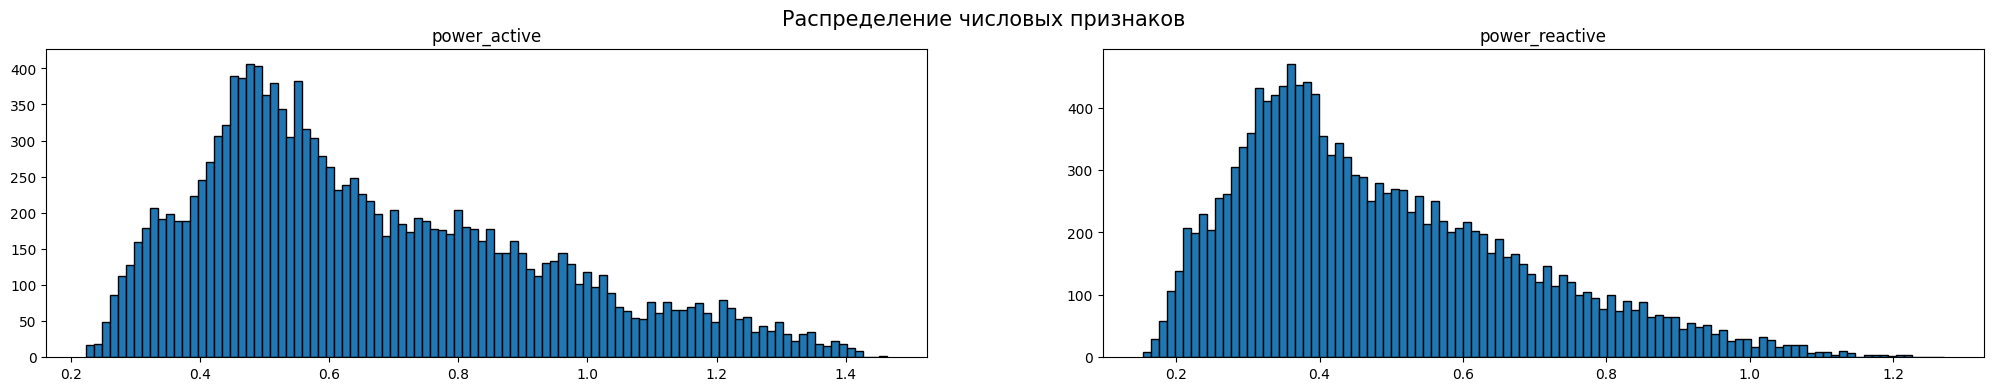

In [48]:
hist_plot(df_data_arc, ['power_active', 'power_reactive'], 2)

Гистограммы распределения

1. power_active:
   - Распределение похоже на нормальное, с небольшим уклоном направо.

2. power_reactive:
   - Распределение также похоже на нормальное, но с более ярким правым уклоном.

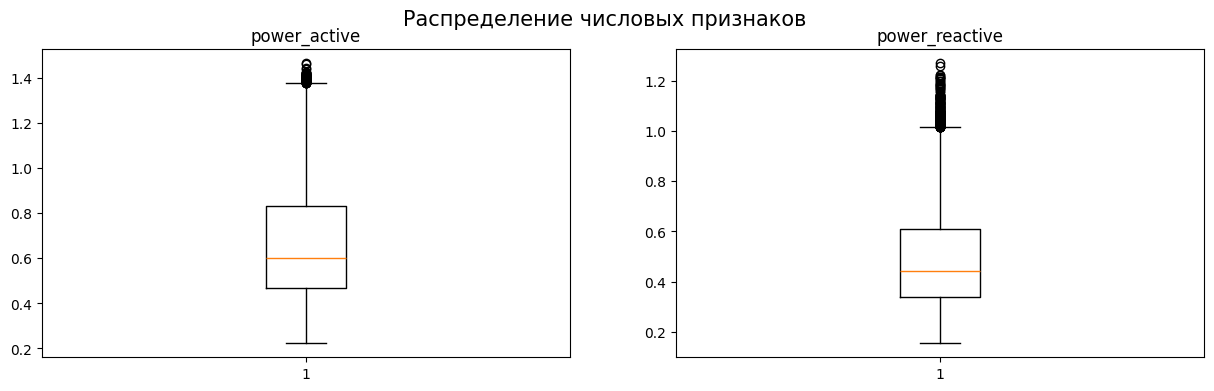

In [49]:
box_plot(df_data_arc, ['power_active', 'power_reactive'], 2)

Боксплоты

1. power_active:
   - Присутствуют выбросы (точки за пределами "усов" боксплота), которые находятся выше верхнего квартиля.
   - Это указывает на наличие небольшого количества аномально высоких значений потребления.

2. power_reactive:
   - Также наблюдаются выбросы, преимущественно сосредоточенные выше верхнего квартиля.
   - Это свидетельствует об аномально высоких значений потребления.

### Дополнительные признаки

#### Длительность нагрева

In [50]:
def duration(data):
    data["heat_duration"] = (data["heat_end"] - data["heat_begin"]).total_seconds()
    return data

In [51]:
df_data_arc = df_data_arc.apply(duration, axis=1)

In [52]:
df_data_arc.head()

,key,heat_begin,heat_end,power_active,power_reactive,heat_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0


In [53]:
df_data_arc.describe()

,key,heat_begin,heat_end,power_active,power_reactive,heat_duration
count,14872.000000,14872,14872,14872.000000,14872.000000,14872.000000
mean,1615.085732,2019-07-05 12:17:07.251008512,2019-07-05 12:19:58.939012864,0.662753,0.487112,171.688004
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,0.153777,11.000000
25%,806.000000,2019-06-03 23:00:25.249999872,2019-06-03 23:04:15.750000128,0.467114,0.337175,107.000000
50%,1616.000000,2019-07-03 01:13:25,2019-07-03 01:15:47,0.599587,0.441667,147.000000
75%,2429.000000,2019-08-07 22:59:29.500000,2019-08-07 23:01:33,0.830314,0.608201,214.000000
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284,907.000000
std,934.661090,NaN,NaN,0.258916,0.197623,98.193604


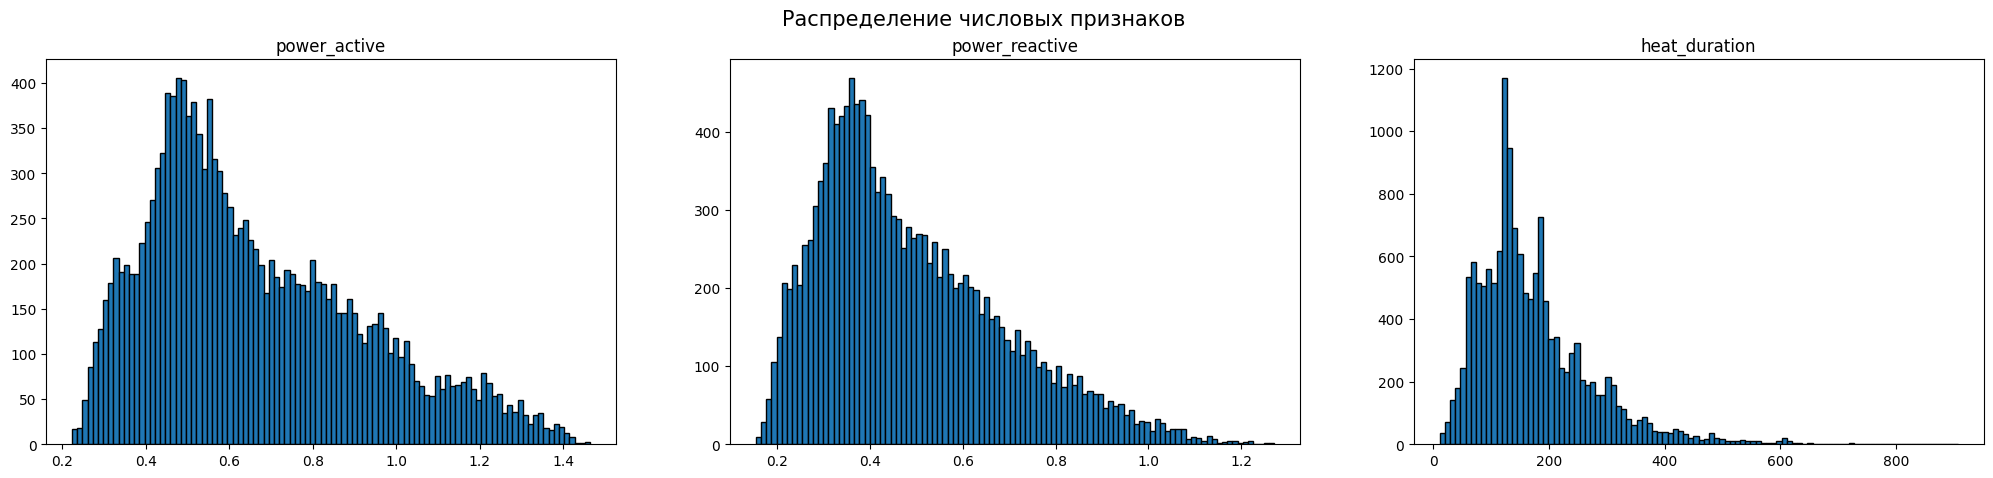

In [54]:
hist_plot(df_data_arc, ['power_active', 'power_reactive', 'heat_duration'])

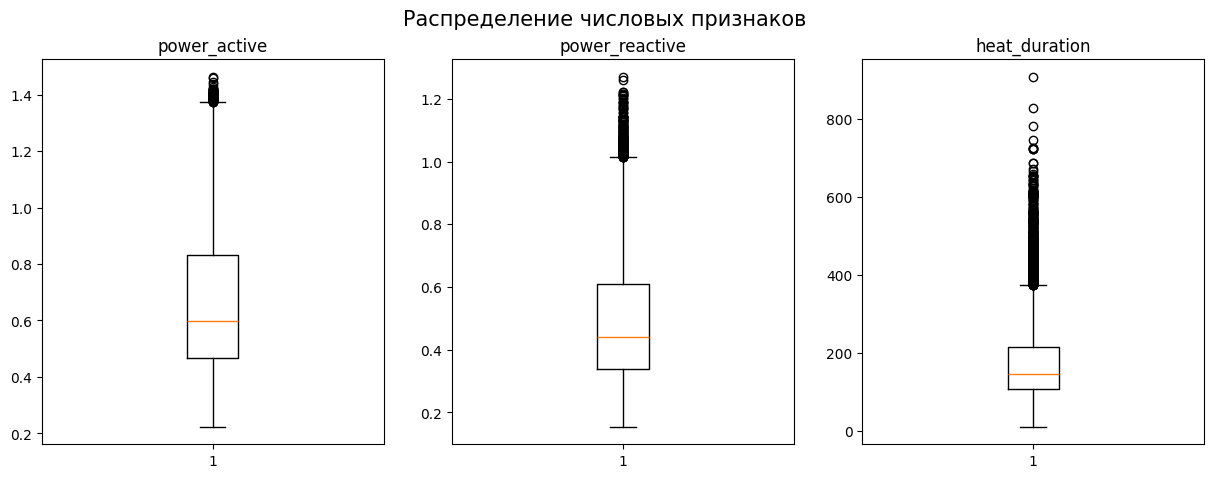

In [55]:
box_plot(df_data_arc, ['power_active', 'power_reactive', 'heat_duration'])

#### Полная мощность

Рассчитаем колонку полной мощности, которая равна квадратному корню из суммы квадратов активной и реактивной мощностей.

In [56]:
df_data_arc['power_all'] = np.sqrt(pow(df_data_arc['power_active'], 2) + pow(df_data_arc['power_reactive'], 2))

In [57]:
df_data_arc.head()

,key,heat_begin,heat_end,power_active,power_reactive,heat_duration,power_all
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934


#### Потребление электроэнергии

Потребление электроэнергии, равное произведению полной мощности на время нагрева.

In [58]:
df_data_arc['consumption'] = df_data_arc['power_all'] * df_data_arc['heat_duration']

In [59]:
df_data_arc.head()

,key,heat_begin,heat_end,power_active,power_reactive,heat_duration,power_all,consumption
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,159.830252


### Агрегирование наблюдений

Сначала удалим колонки `heat_begin`, `heat_end`

In [60]:
df_data_arc = df_data_arc.drop(['heat_begin', 'heat_end'], axis=1)

In [61]:
df_data_arc = (
    df_data_arc.groupby("key")
    .agg(
        {
            "key": "count",
            "power_active": "sum",
            "power_reactive": "sum",
            "heat_duration": "sum",
            "power_all": "sum",
            "consumption": "sum",
        }
    )
    .rename(columns={"key": "heat_count"})
)

In [62]:
df_data_arc.head()

,heat_count,power_active,power_reactive,heat_duration,power_all,consumption
key,,,,,,
1,5,3.036730,2.142821,1098.0,3.718736,770.282114
2,4,2.139408,1.453357,811.0,2.588349,481.760005
3,5,4.063641,2.937457,655.0,5.019223,722.837668
4,4,2.706489,2.056992,741.0,3.400038,683.455597
5,4,2.252950,1.687991,869.0,2.816980,512.169934


In [63]:
df_data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3213 entries, 1 to 3241
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   heat_count      3213 non-null   int64  
 1   power_active    3213 non-null   float64
 2   power_reactive  3213 non-null   float64
 3   heat_duration   3213 non-null   float64
 4   power_all       3213 non-null   float64
 5   consumption     3213 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 175.7 KB


## Данные об объёме сыпучих материалов (df_data_bulk)

In [64]:
df_data_bulk.sample(5, random_state=RANDOM_STATE)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
1756,1817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,101.0,NaN
1318,1370,NaN,NaN,NaN,NaN,NaN,167.0,NaN,NaN,NaN,NaN,NaN,256.0,NaN,102.0,NaN
2176,2255,NaN,NaN,NaN,179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.0,NaN,98.0,105.0
3087,3197,NaN,NaN,154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,308.0,NaN,148.0,206.0
2712,2813,NaN,NaN,NaN,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.0,NaN,104.0,106.0


In [65]:
df_data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


### Проверка пропусков

In [66]:
df_data_bulk.isnull().sum()

key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64

Пропуск означает, что материал не добавляли в партию. По этому заполним их нулями.

In [67]:
df_data_bulk = df_data_bulk.fillna(0)

In [68]:
df_data_bulk.isnull().sum()

key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

Пропуски в таблице отсутствуют.

### Проверка дубликатов

In [69]:
df_data_bulk[df_data_bulk.duplicated()]

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15


Дубликаты в таблице отсутствуют.

### Проверка аномалий

Зададим столбец key как индекс для единообразия таблиц и упрощения их объединения

In [70]:
df_data_bulk = df_data_bulk.set_index('key')

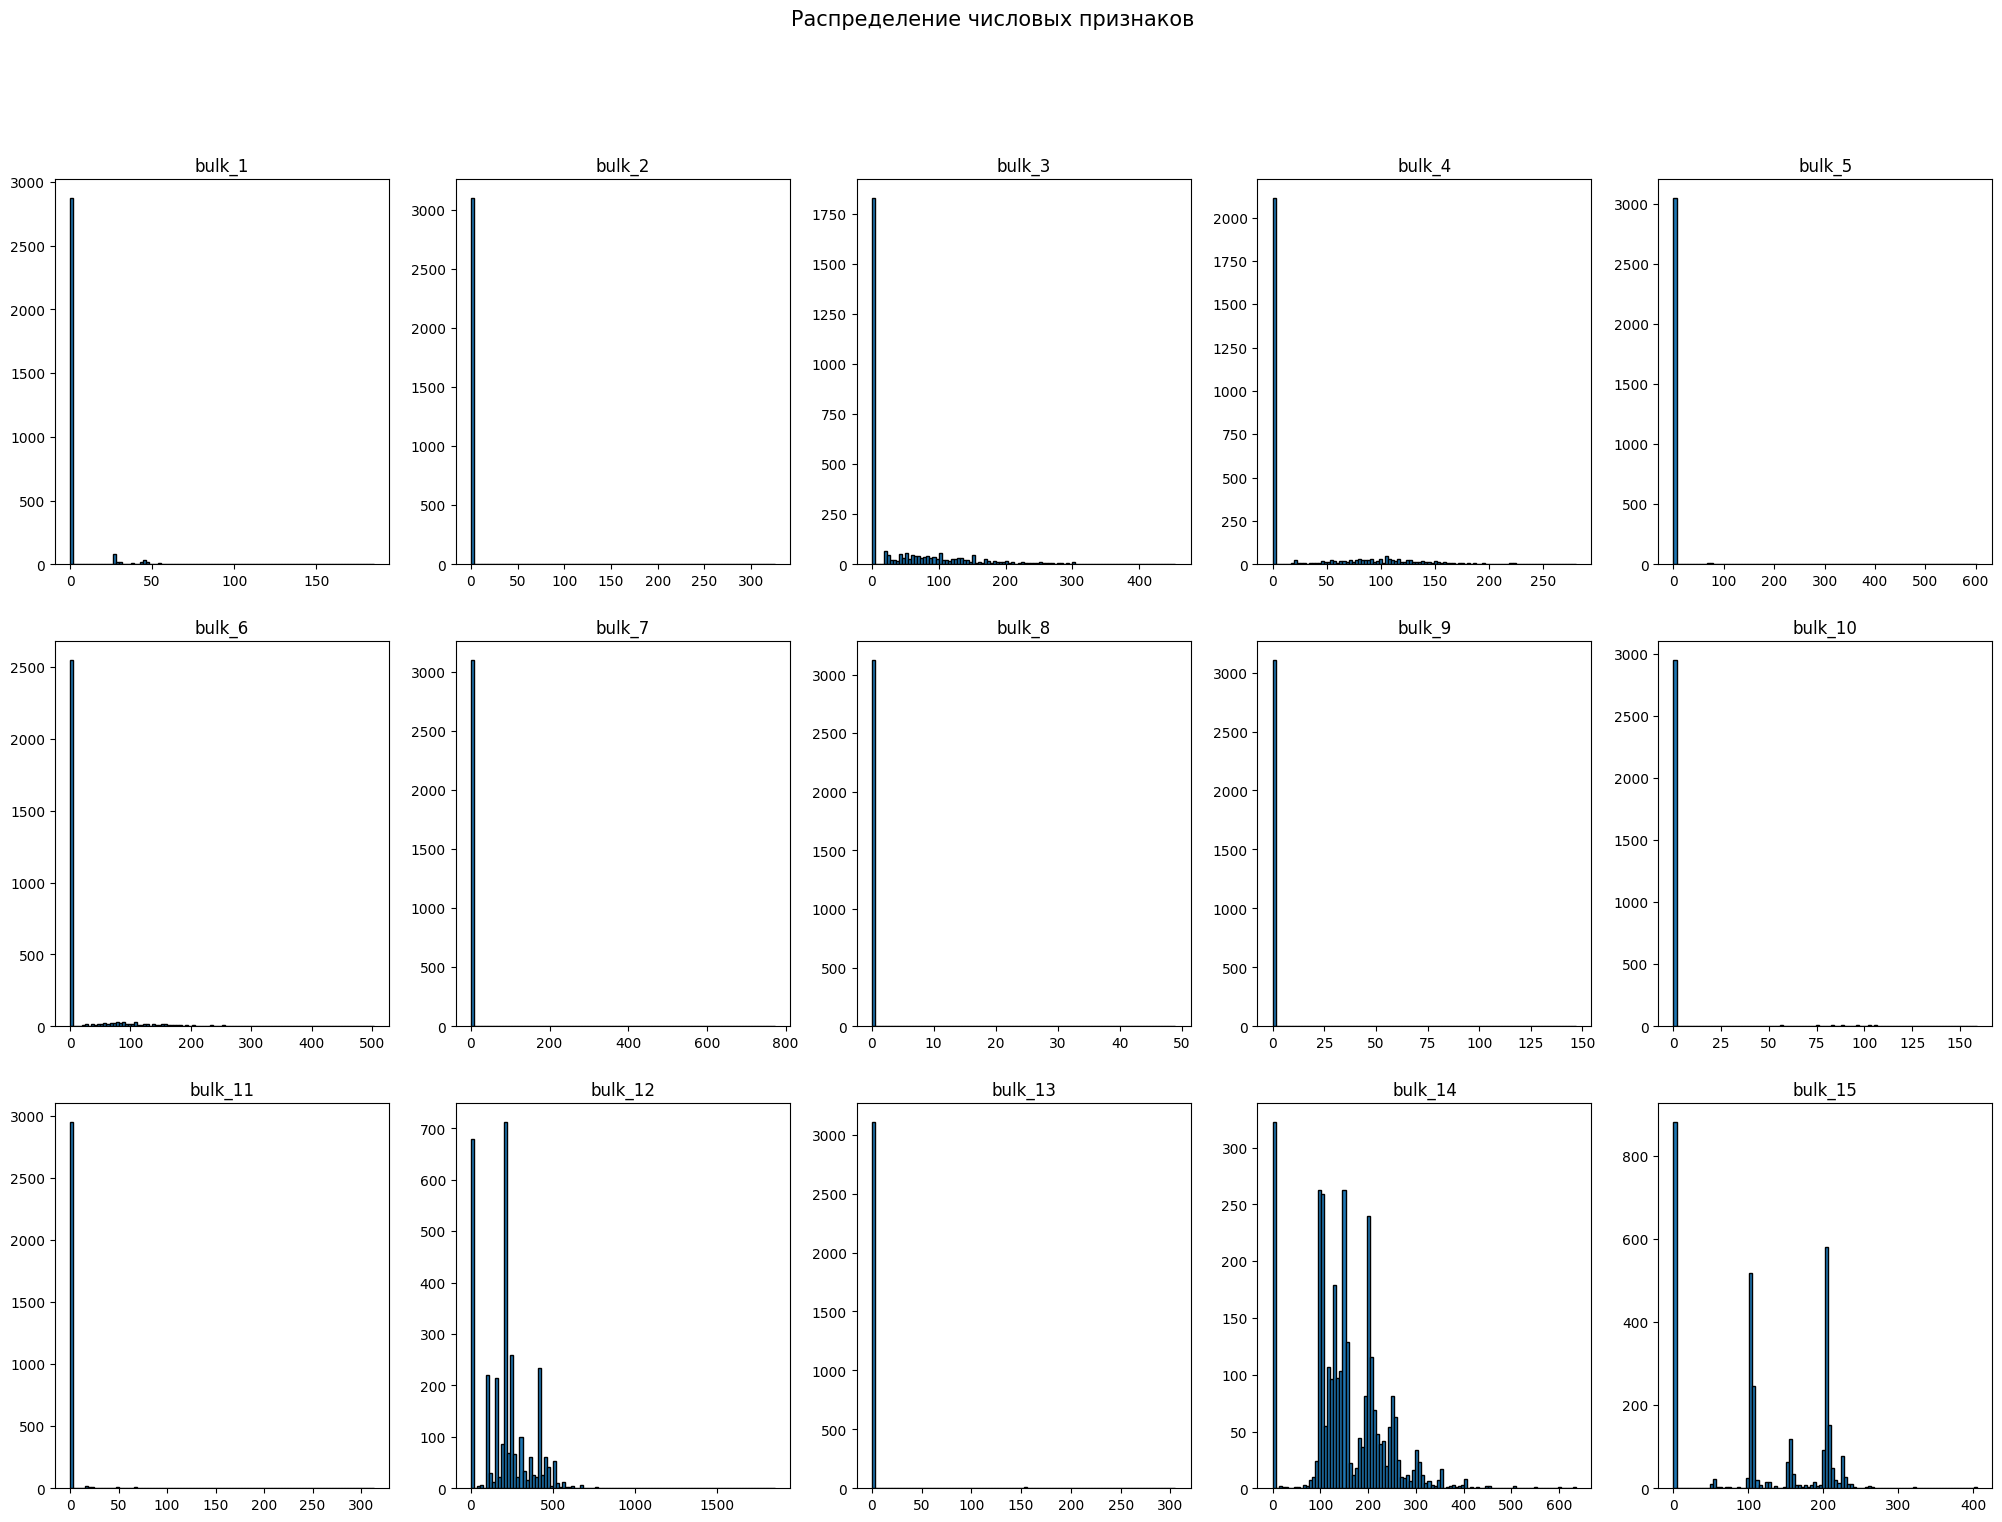

In [71]:
hist_plot(data=df_data_bulk, num_cols=df_data_bulk.columns, n=5)

Добавление сыпучих материалов не имеет каких-то характерных распределений.

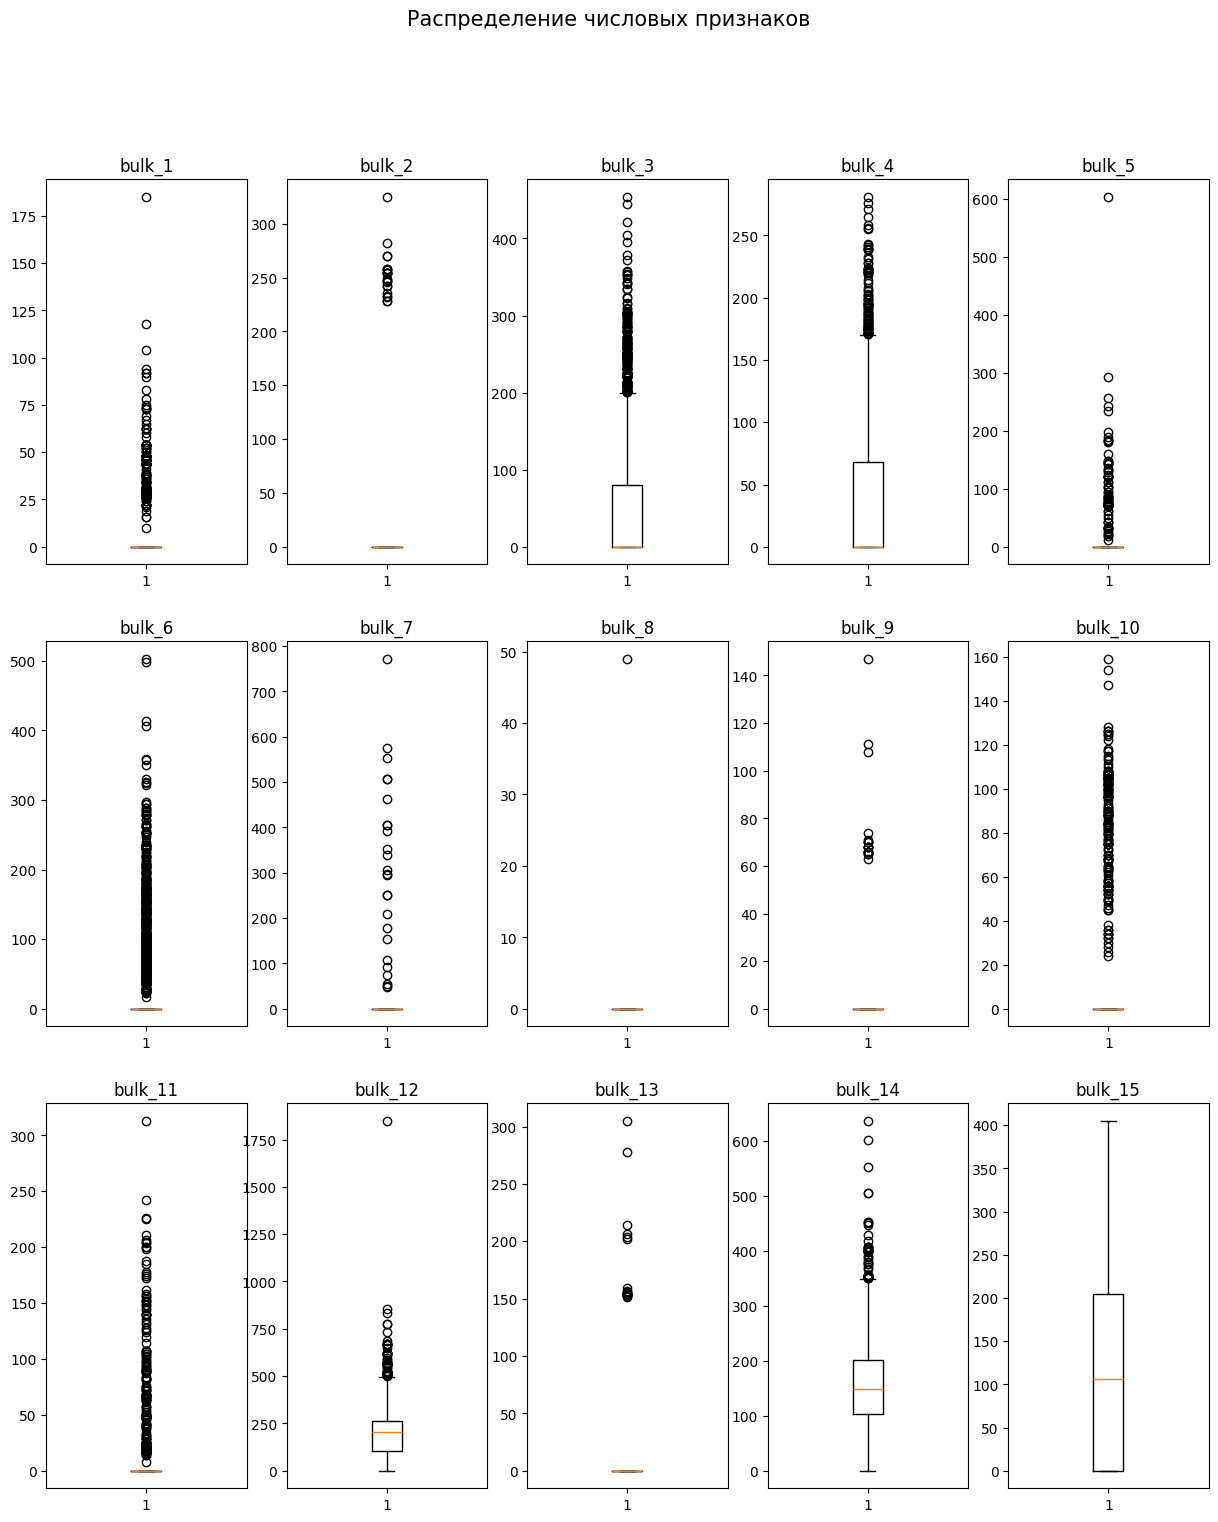

In [72]:
box_plot(data=df_data_bulk, num_cols=df_data_bulk.columns, n=5)

Большинство сыпучих материалов редко добавляется в сплавы, поэтому их добавление выглядит, как выброс, такие данные сохраним.

## Данные о времени подачи сыпучих материалов (df_data_bulk_time)

Теперь извлекаем время и переводим его в числовой формат (количество минут с начала дня)

In [73]:
for index in range(1,16):
    col = f'bulk_{index}_time'
    df_data_bulk_time[col] = df_data_bulk_time[col].apply(lambda x: x.hour * 60 + x.minute + x.second / 60 if pd.notnull(x) else None)
df_data_bulk_time.sample(5, random_state=RANDOM_STATE)

,key,bulk_1_time,bulk_2_time,bulk_3_time,bulk_4_time,bulk_5_time,bulk_6_time,bulk_7_time,bulk_8_time,bulk_9_time,bulk_10_time,bulk_11_time,bulk_12_time,bulk_13_time,bulk_14_time,bulk_15_time
1756,1817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1418.000000,NaN,1415.050000,NaN
1318,1370,NaN,NaN,NaN,NaN,NaN,253.133333,NaN,NaN,NaN,NaN,NaN,253.133333,NaN,247.450000,NaN
2176,2255,NaN,NaN,NaN,972.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,972.083333,NaN,966.866667,960.333333
3087,3197,NaN,NaN,309.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,309.333333,NaN,303.116667,309.333333
2712,2813,NaN,NaN,NaN,463.550000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,472.300000,NaN,489.866667,486.966667


In [74]:
df_data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3129 non-null   int64  
 1   bulk_1_time   252 non-null    float64
 2   bulk_2_time   22 non-null     float64
 3   bulk_3_time   1298 non-null   float64
 4   bulk_4_time   1014 non-null   float64
 5   bulk_5_time   77 non-null     float64
 6   bulk_6_time   576 non-null    float64
 7   bulk_7_time   25 non-null     float64
 8   bulk_8_time   1 non-null      float64
 9   bulk_9_time   19 non-null     float64
 10  bulk_10_time  176 non-null    float64
 11  bulk_11_time  177 non-null    float64
 12  bulk_12_time  2450 non-null   float64
 13  bulk_13_time  18 non-null     float64
 14  bulk_14_time  2806 non-null   float64
 15  bulk_15_time  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


### Проверка пропусков

In [75]:
df_data_bulk_time.isnull().sum()

key                0
bulk_1_time     2877
bulk_2_time     3107
bulk_3_time     1831
bulk_4_time     2115
bulk_5_time     3052
bulk_6_time     2553
bulk_7_time     3104
bulk_8_time     3128
bulk_9_time     3110
bulk_10_time    2953
bulk_11_time    2952
bulk_12_time     679
bulk_13_time    3111
bulk_14_time     323
bulk_15_time     881
dtype: int64

Пропуск означает, что материал не добавляли в партию. По этому заполним их нулями.

In [76]:
df_data_bulk_time = df_data_bulk_time.fillna(0)

In [77]:
df_data_bulk_time.isnull().sum()

key             0
bulk_1_time     0
bulk_2_time     0
bulk_3_time     0
bulk_4_time     0
bulk_5_time     0
bulk_6_time     0
bulk_7_time     0
bulk_8_time     0
bulk_9_time     0
bulk_10_time    0
bulk_11_time    0
bulk_12_time    0
bulk_13_time    0
bulk_14_time    0
bulk_15_time    0
dtype: int64

Пропуски в таблице отсутствуют.

### Проверка дубликатов

In [78]:
df_data_bulk_time[df_data_bulk_time.duplicated()]

,key,bulk_1_time,bulk_2_time,bulk_3_time,bulk_4_time,bulk_5_time,bulk_6_time,bulk_7_time,bulk_8_time,bulk_9_time,bulk_10_time,bulk_11_time,bulk_12_time,bulk_13_time,bulk_14_time,bulk_15_time


Дубликаты в таблице отсутствуют.

### Проверка аномалий

Зададим столбец key как индекс для единообразия таблиц и упрощения их объединения

In [79]:
df_data_bulk_time = df_data_bulk_time.set_index('key')

In [80]:
df_data_bulk_time.describe()

,bulk_1_time,bulk_2_time,bulk_3_time,bulk_4_time,bulk_5_time,bulk_6_time,bulk_7_time,bulk_8_time,bulk_9_time,bulk_10_time,bulk_11_time,bulk_12_time,bulk_13_time,bulk_14_time,bulk_15_time
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,62.050506,4.735949,302.069836,242.098210,20.493235,131.639794,6.860696,0.330739,4.348695,41.608224,37.621865,571.920198,3.179956,654.932641,524.402999
std,239.783086,66.843398,445.916709,430.490396,142.425155,330.153718,85.740312,18.500719,58.378585,198.082366,184.509516,477.076759,48.941549,454.373865,486.910734
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.550000,0.000000,239.366667,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,536.400000,0.000000,656.833333,439.150000
75%,0.000000,0.000000,581.333333,314.383333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,992.200000,0.000000,1048.000000,961.566667
max,1439.966667,1370.483333,1438.866667,1438.433333,1429.833333,1439.250000,1428.783333,1034.883333,1043.400000,1429.716667,1435.316667,1439.766667,1210.316667,1439.950000,1439.333333


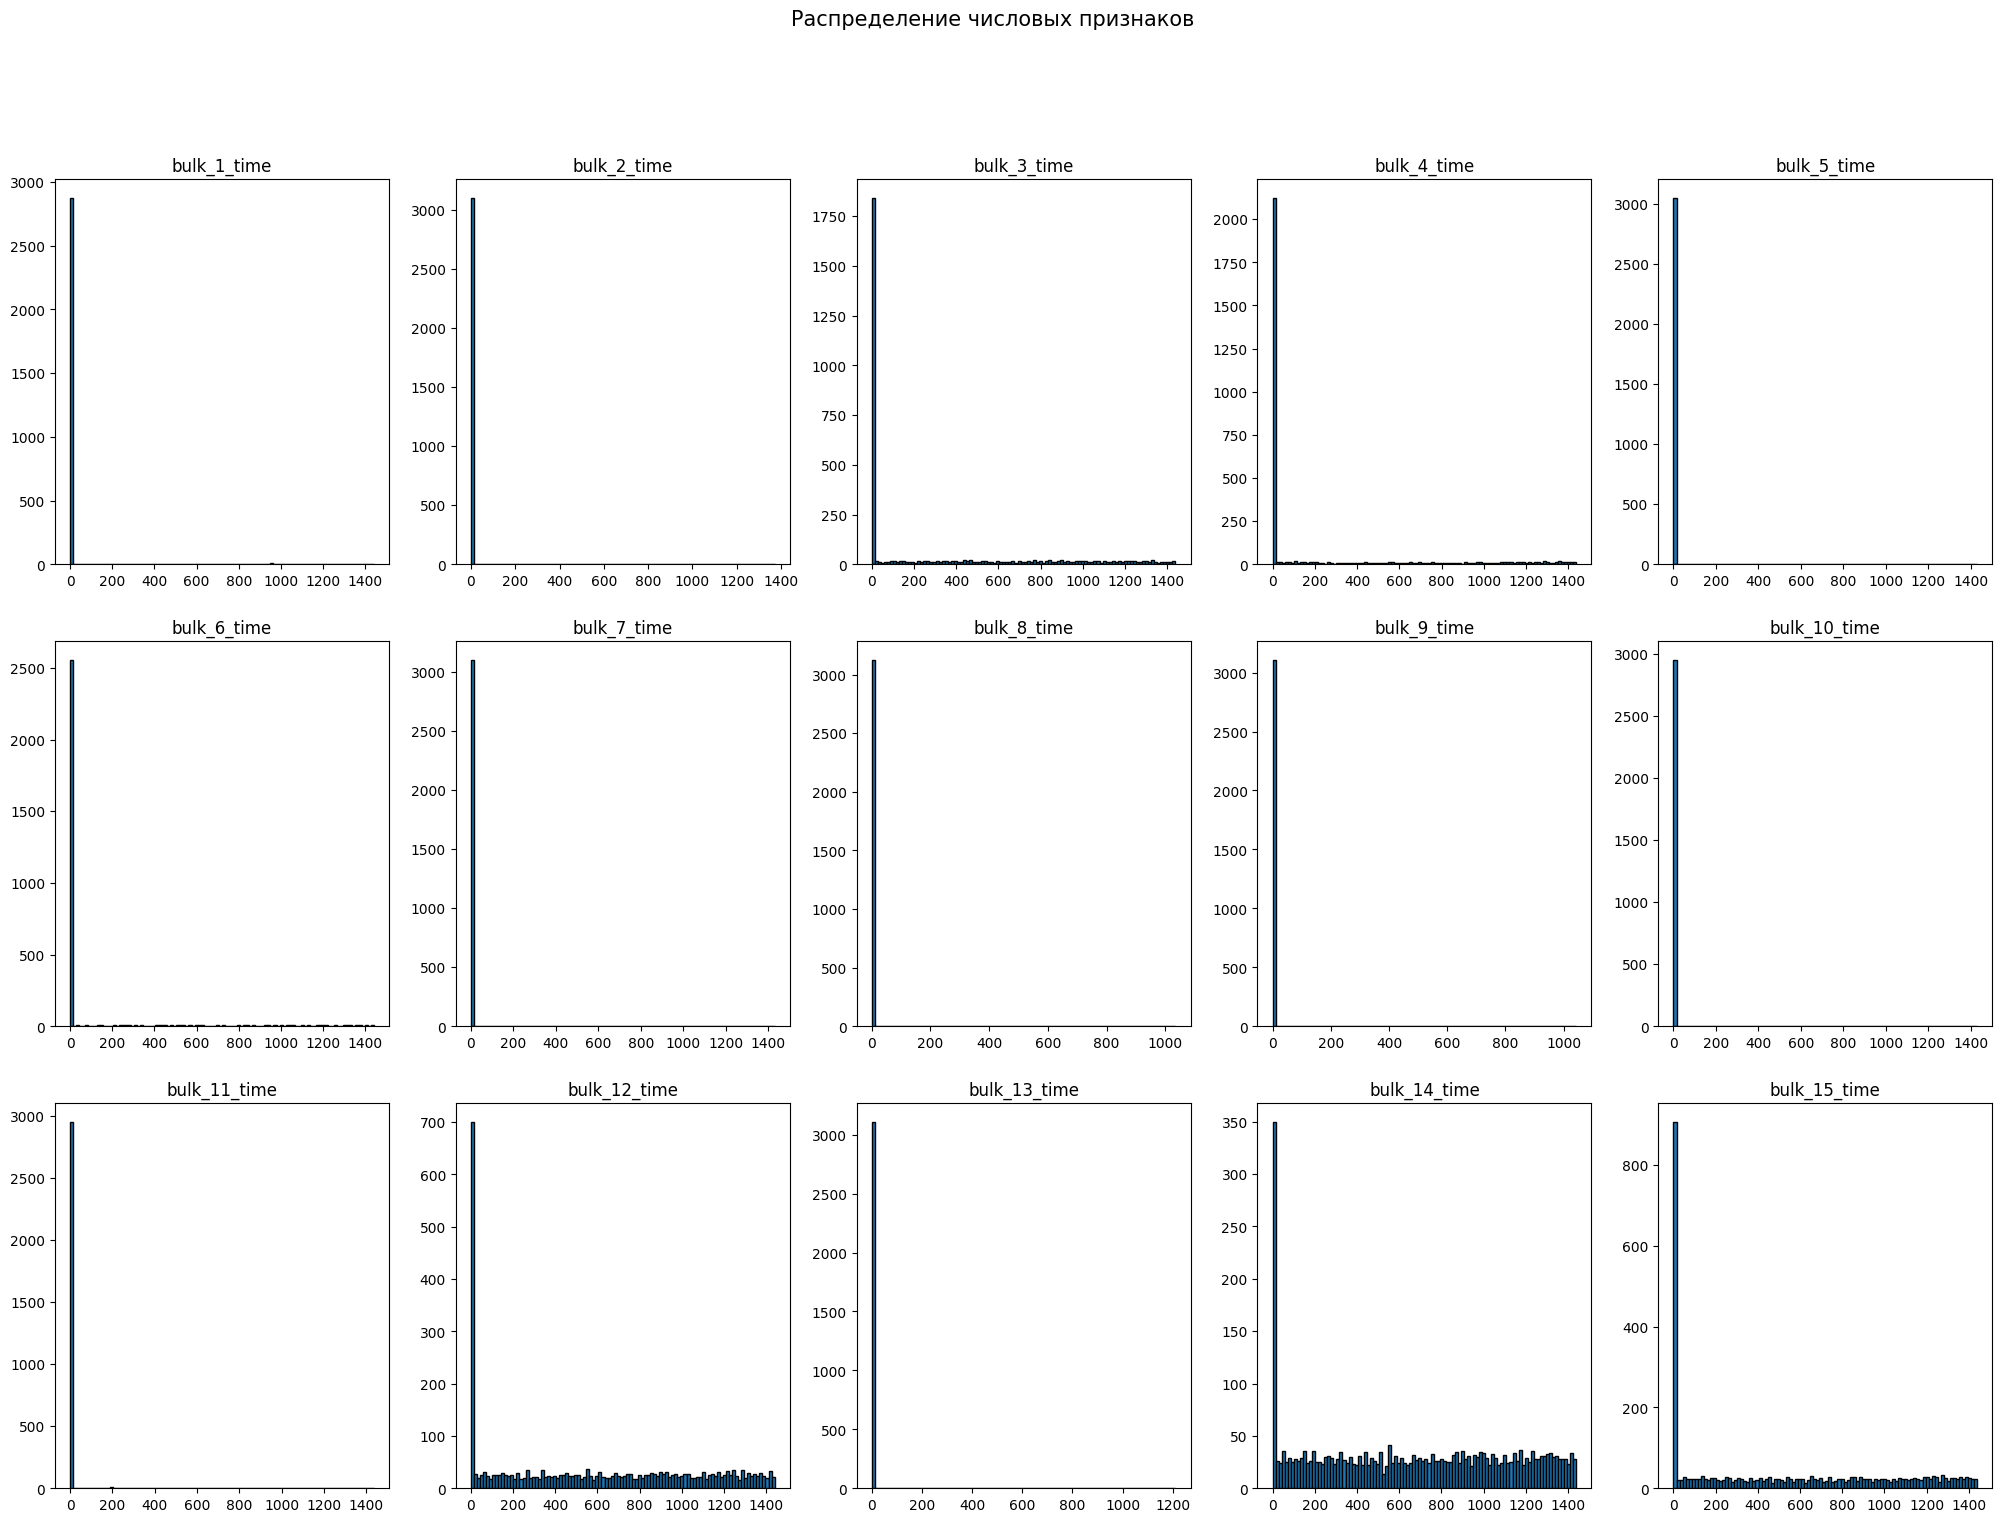

In [82]:
hist_plot(data=df_data_bulk_time, num_cols=df_data_bulk_time.columns, n=5)

Наличие данных в таблице со временем подачи соответствует наличию факта подачи в предыдущей таблице.

## Данные о продувке сплава газом (df_data_gas)

In [83]:
df_data_gas.sample(5, random_state=RANDOM_STATE)

,key,gas
126,127,9.135562
1672,1675,17.441095
3153,3156,9.504270
1061,1064,12.680359
2258,2261,30.836658


In [84]:
df_data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


### Проверка пропусков

In [85]:
df_data_gas.isnull().sum()

key    0
gas    0
dtype: int64

Пропуски в таблице отсутствуют.

### Проверка дубликатов

In [86]:
df_data_gas[df_data_gas.duplicated()]

,key,gas


Дубликаты в таблице отсутствуют.

### Проверка аномалий

Зададим столбец key как индекс для единообразия таблиц и упрощения их объединения

In [87]:
df_data_gas = df_data_gas.set_index('key')

<Figure size 500x500 with 0 Axes>

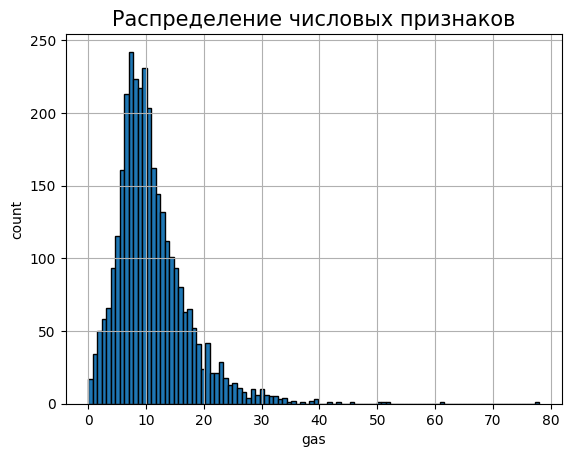

In [88]:
hist_plot(data=df_data_gas, num_cols=df_data_gas.columns, n=1)

Наблюдается значительная вариативность в данных. Это может быть связано с особенностями процесса или различиями в требуемых условиях продувки.

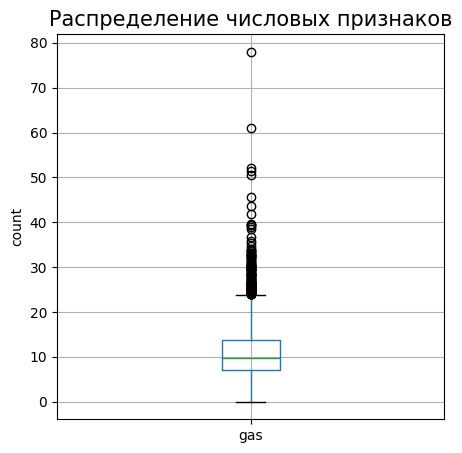

In [89]:
box_plot(data=df_data_gas, num_cols=df_data_gas.columns, n=1)

Основная часть данных сосредоточена в нижней части графика, что может указывать на преобладание более низких значений газовой продувки.

## Данные об измерениях температуры (df_data_temp)

In [90]:
df_data_temp.sample(5, random_state=RANDOM_STATE)

,key,mesaure_time,temperature
11836,2108,2019-07-27 15:17:49,1582.0
14851,2654,2019-08-16 10:41:22,NaN
573,102,2019-05-07 04:04:02,1606.0
17027,3043,2019-08-30 22:31:15,NaN
1748,312,2019-05-15 12:04:21,1579.0


In [91]:
df_data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   mesaure_time  18092 non-null  datetime64[ns]
 2   temperature   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


### Проверка пропусков

In [92]:
df_data_temp.isnull().sum()

key                0
mesaure_time       0
temperature     3427
dtype: int64

Пропуски в таблице свидетельствуют о неправильности измерений, избавимся от них.

In [93]:
df_data_temp = df_data_temp.dropna()

In [94]:
df_data_temp.isnull().sum()

key             0
mesaure_time    0
temperature     0
dtype: int64

Пропуски в таблице отсутствуют.

### Проверка дубликатов

In [95]:
df_data_temp[df_data_temp.duplicated()]

,key,mesaure_time,temperature


Дубликаты в таблице отсутствуют.

### Проверка аномалий

Проверим значения температуры ниже 1500 градусов, т.к. они являются аномальными по информации от заказчика.

In [96]:
df_data_temp.query('temperature < 1500')

,key,mesaure_time,temperature
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [97]:
df_data_temp = df_data_temp.query('temperature >= 1500')

### Агрегирование наблюдений

In [98]:
df_data_temp = (
    df_data_temp.groupby("key")
    .agg(
        {
            "key": "count",
            "temperature": ["first", "last"]
        }
    )
)

In [99]:
df_data_temp.columns = df_data_temp.columns.droplevel(0)
df_data_temp.columns = ['temp_count', 'temp_first', 'temp_last']

In [100]:
df_data_temp.head()

,temp_count,temp_first,temp_last
key,,,
1,6,1571.0,1613.0
2,5,1581.0,1602.0
3,6,1596.0,1599.0
4,5,1601.0,1625.0
5,5,1576.0,1602.0


In [101]:
df_data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3215 entries, 1 to 3241
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp_count  3215 non-null   int64  
 1   temp_first  3215 non-null   float64
 2   temp_last   3215 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 100.5 KB


In [102]:
df_data_temp.describe()

,temp_count,temp_first,temp_last
count,3215.000000,3215.000000,3215.000000
mean,4.559876,1589.195023,1594.049767
std,2.405800,25.015034,18.649454
min,1.000000,1519.000000,1529.000000
25%,3.000000,1572.000000,1585.000000
50%,5.000000,1588.000000,1593.000000
75%,6.000000,1606.000000,1600.000000
max,17.000000,1684.000000,1700.000000


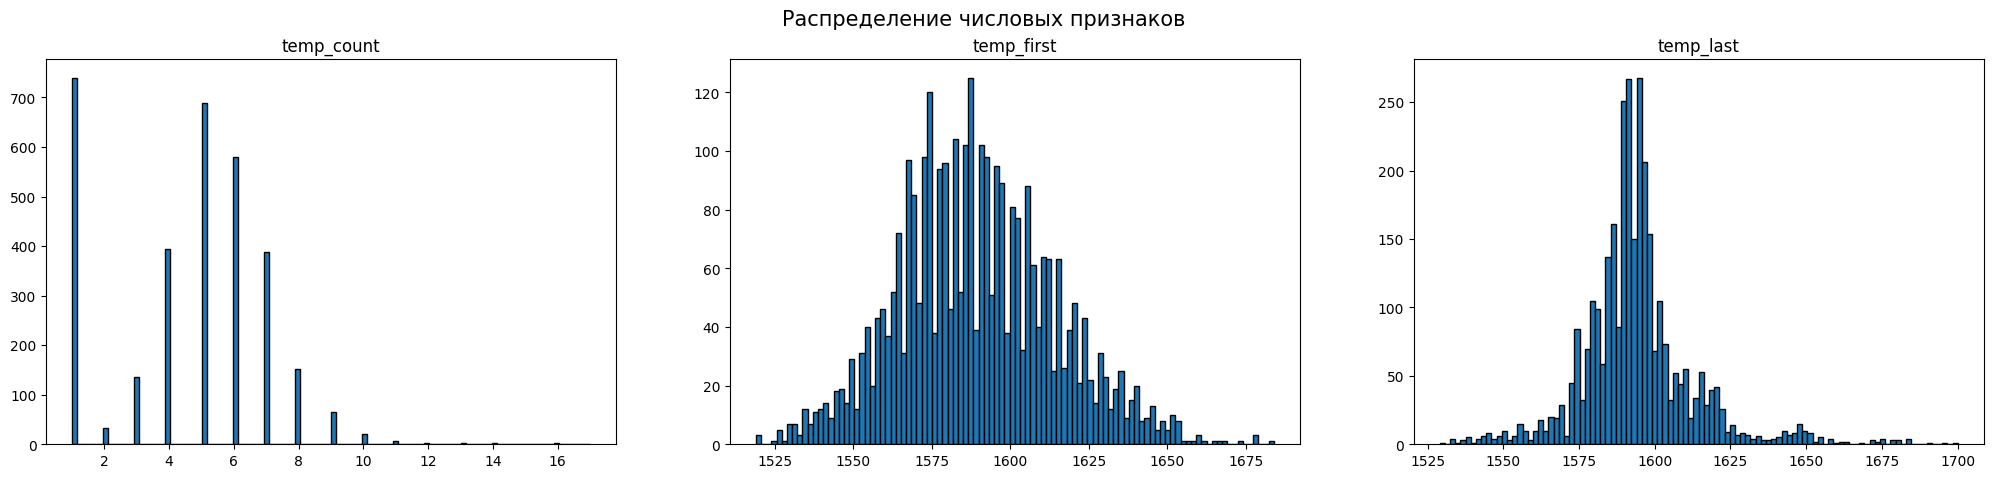

In [103]:
hist_plot(data=df_data_temp, num_cols=df_data_temp.columns, n=3)

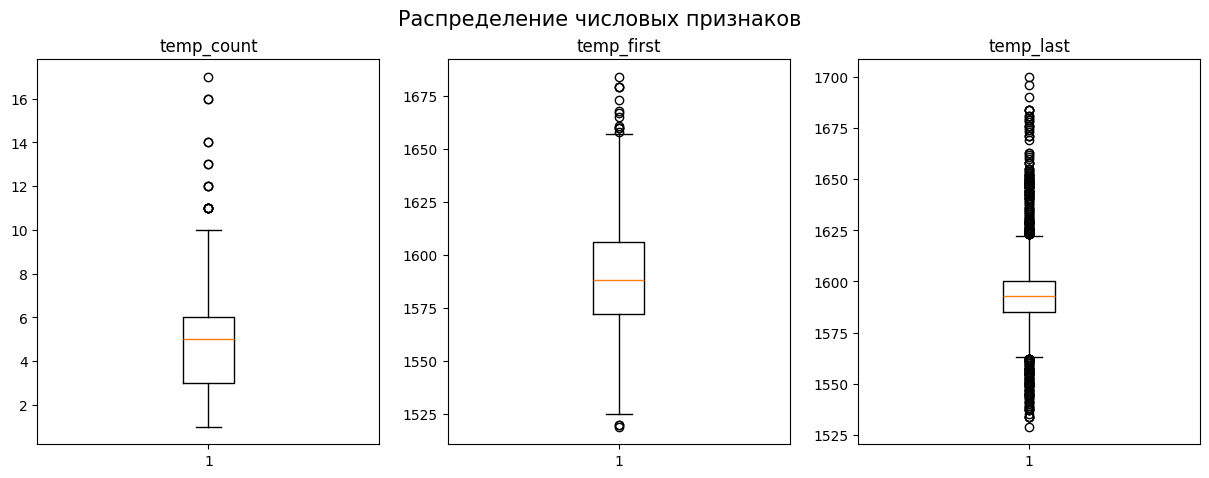

In [104]:
box_plot(data=df_data_temp, num_cols=df_data_temp.columns, n=3)

Распределение температур похоже на нормальное. 

## Данные об объёме проволочных материалов (df_data_wire)

In [105]:
df_data_wire.sample(5, random_state=RANDOM_STATE)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
96,112,92.994720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,2104,4.018560,NaN,90.138054,40.069122,NaN,78.078002,NaN,NaN,NaN
79,94,37.215358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2893,3052,60.278397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2588,2722,123.221290,NaN,NaN,NaN,NaN,35.178001,NaN,NaN,NaN


In [106]:
df_data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


### Проверка пропусков

In [107]:
df_data_wire.isnull().sum()

key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

В таблице большое количество пропусков, что свидетельствует о недобавлении данного проволочного материала. Можно заполнить данные пропуски нулями.

In [108]:
df_data_wire = df_data_wire.fillna(0)

In [109]:
df_data_wire.isnull().sum()

key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

Пропуски в таблице отсутствуют.

### Проверка дубликатов

In [110]:
df_data_wire[df_data_wire.duplicated()]

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9


Дубликаты в таблице отсутствуют.

### Проверка аномалий

Зададим столбец key как индекс для единообразия таблиц и упрощения их объединения

In [111]:
df_data_wire = df_data_wire.set_index('key')

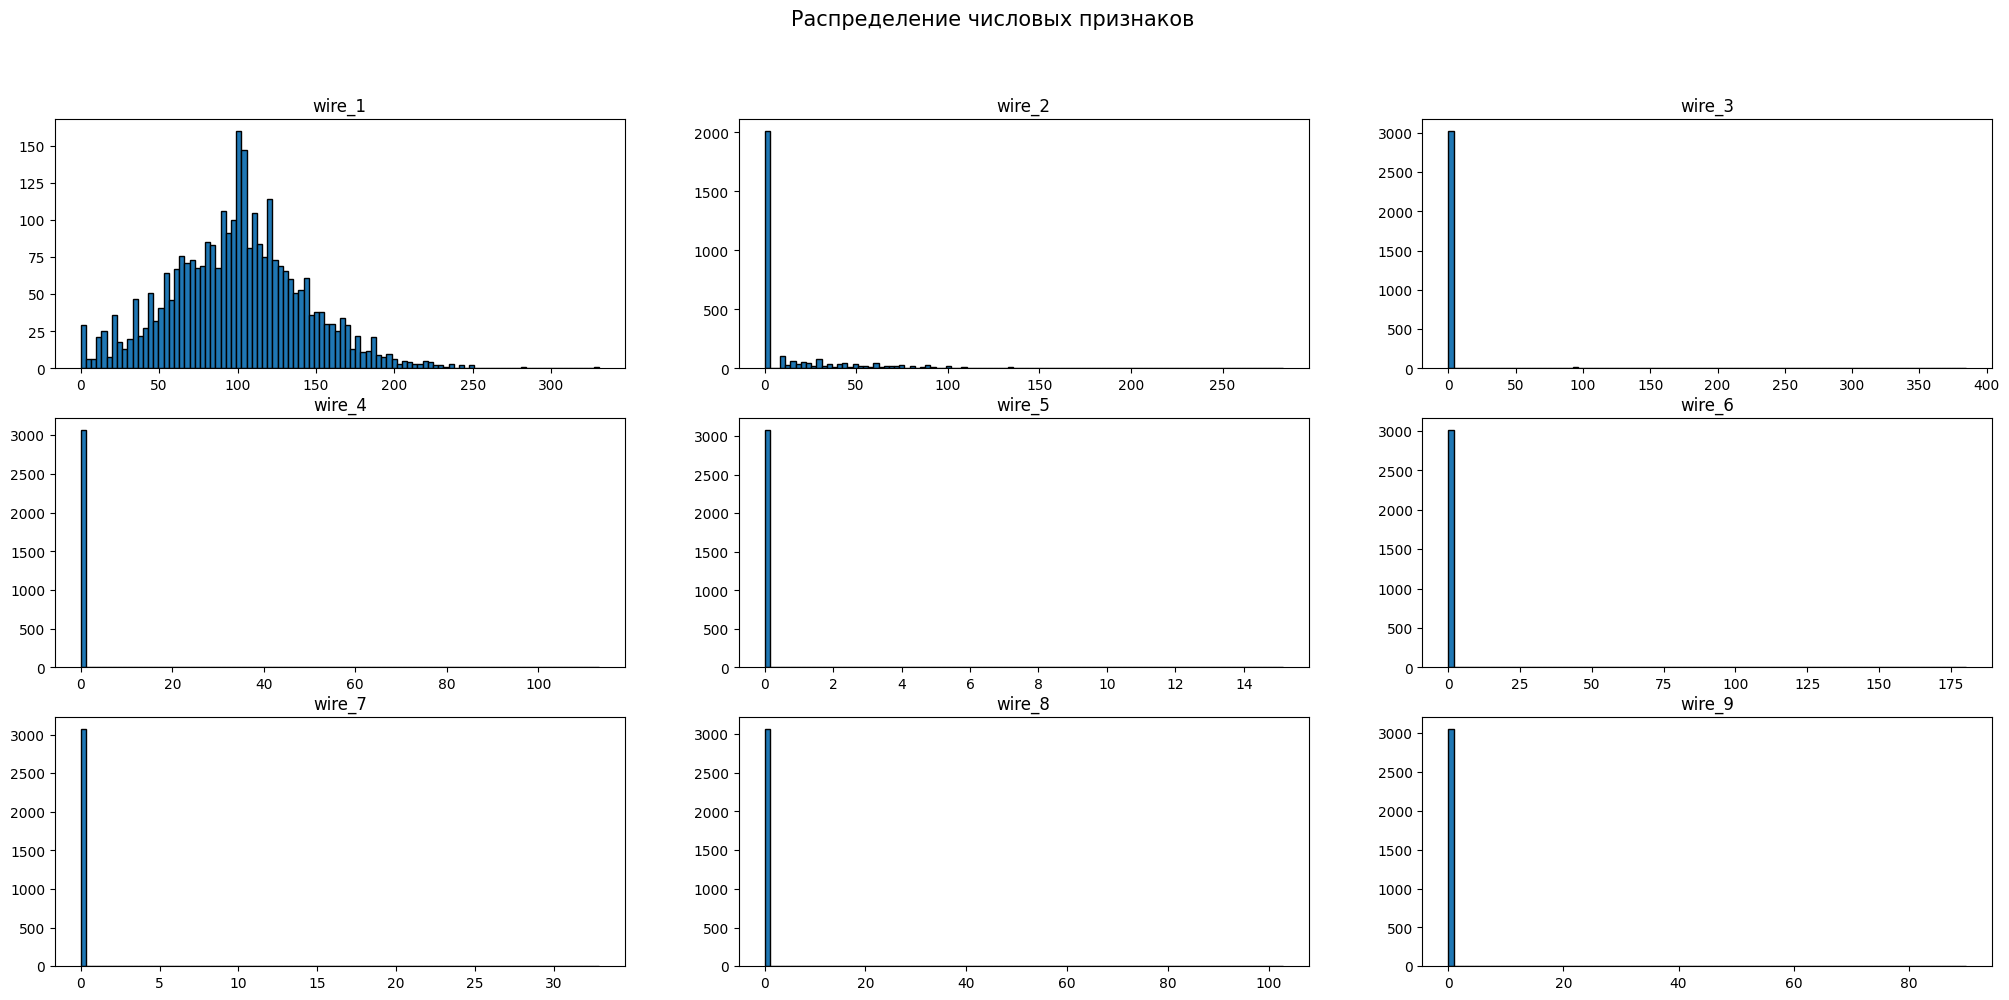

In [112]:
hist_plot(data=df_data_wire, num_cols=df_data_wire.columns, n=3)

Распределение добавления первого материала похоже на нормальное. Для всех остальных материалов в распределении явно преобладает 0.

## Данные о времени подачи проволочных материалов (df_data_wire_time)

Теперь извлекаем время и переводим его в числовой формат (количество минут с начала дня)

In [113]:
for index in range(1,10):
    col = f'wire_{index}_time'
    df_data_wire_time[col] = df_data_wire_time[col].apply(lambda x: x.hour * 60 + x.minute + x.second / 60 if pd.notnull(x) else None)
df_data_wire_time.sample(5, random_state=RANDOM_STATE)

,key,wire_1_time,wire_2_time,wire_3_time,wire_4_time,wire_5_time,wire_6_time,wire_7_time,wire_8_time,wire_9_time
96,112,832.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,2104,228.816667,NaN,224.016667,205.966667,NaN,191.283333,NaN,NaN,NaN
79,94,1337.116667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2893,3052,364.983333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2588,2722,986.516667,NaN,NaN,NaN,NaN,980.533333,NaN,NaN,NaN


In [114]:
df_data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3081 non-null   int64  
 1   wire_1_time  3055 non-null   float64
 2   wire_2_time  1079 non-null   float64
 3   wire_3_time  63 non-null     float64
 4   wire_4_time  14 non-null     float64
 5   wire_5_time  1 non-null      float64
 6   wire_6_time  73 non-null     float64
 7   wire_7_time  11 non-null     float64
 8   wire_8_time  19 non-null     float64
 9   wire_9_time  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


### Проверка пропусков

In [115]:
df_data_wire_time.isnull().sum()

key               0
wire_1_time      26
wire_2_time    2002
wire_3_time    3018
wire_4_time    3067
wire_5_time    3080
wire_6_time    3008
wire_7_time    3070
wire_8_time    3062
wire_9_time    3052
dtype: int64

Пропуск означает, что материал не добавляли в партию. По этому заполним их нулями.

In [116]:
df_data_wire_time = df_data_wire_time.fillna(0)

In [117]:
df_data_wire_time.isnull().sum()

key            0
wire_1_time    0
wire_2_time    0
wire_3_time    0
wire_4_time    0
wire_5_time    0
wire_6_time    0
wire_7_time    0
wire_8_time    0
wire_9_time    0
dtype: int64

Пропуски в таблице отсутствуют.

### Проверка дубликатов

In [118]:
df_data_wire_time[df_data_wire_time.duplicated()]

,key,wire_1_time,wire_2_time,wire_3_time,wire_4_time,wire_5_time,wire_6_time,wire_7_time,wire_8_time,wire_9_time


Дубликаты в таблице отсутствуют.

### Проверка аномалий

Зададим столбец key как индекс для единообразия таблиц и упрощения их объединения

In [119]:
df_data_wire_time = df_data_wire_time.set_index('key')

In [120]:
df_data_wire_time.describe()

,wire_1_time,wire_2_time,wire_3_time,wire_4_time,wire_5_time,wire_6_time,wire_7_time,wire_8_time,wire_9_time
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,721.913470,252.999059,14.400709,3.747041,0.121551,19.189019,2.608726,4.287093,8.142264
std,424.714030,420.886722,116.064500,62.016054,6.746926,139.130575,51.158670,57.386079,91.633879
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,353.816667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,728.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1096.250000,426.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1439.933333,1438.183333,1427.833333,1401.700000,374.500000,1428.666667,1400.616667,1016.850000,1388.283333


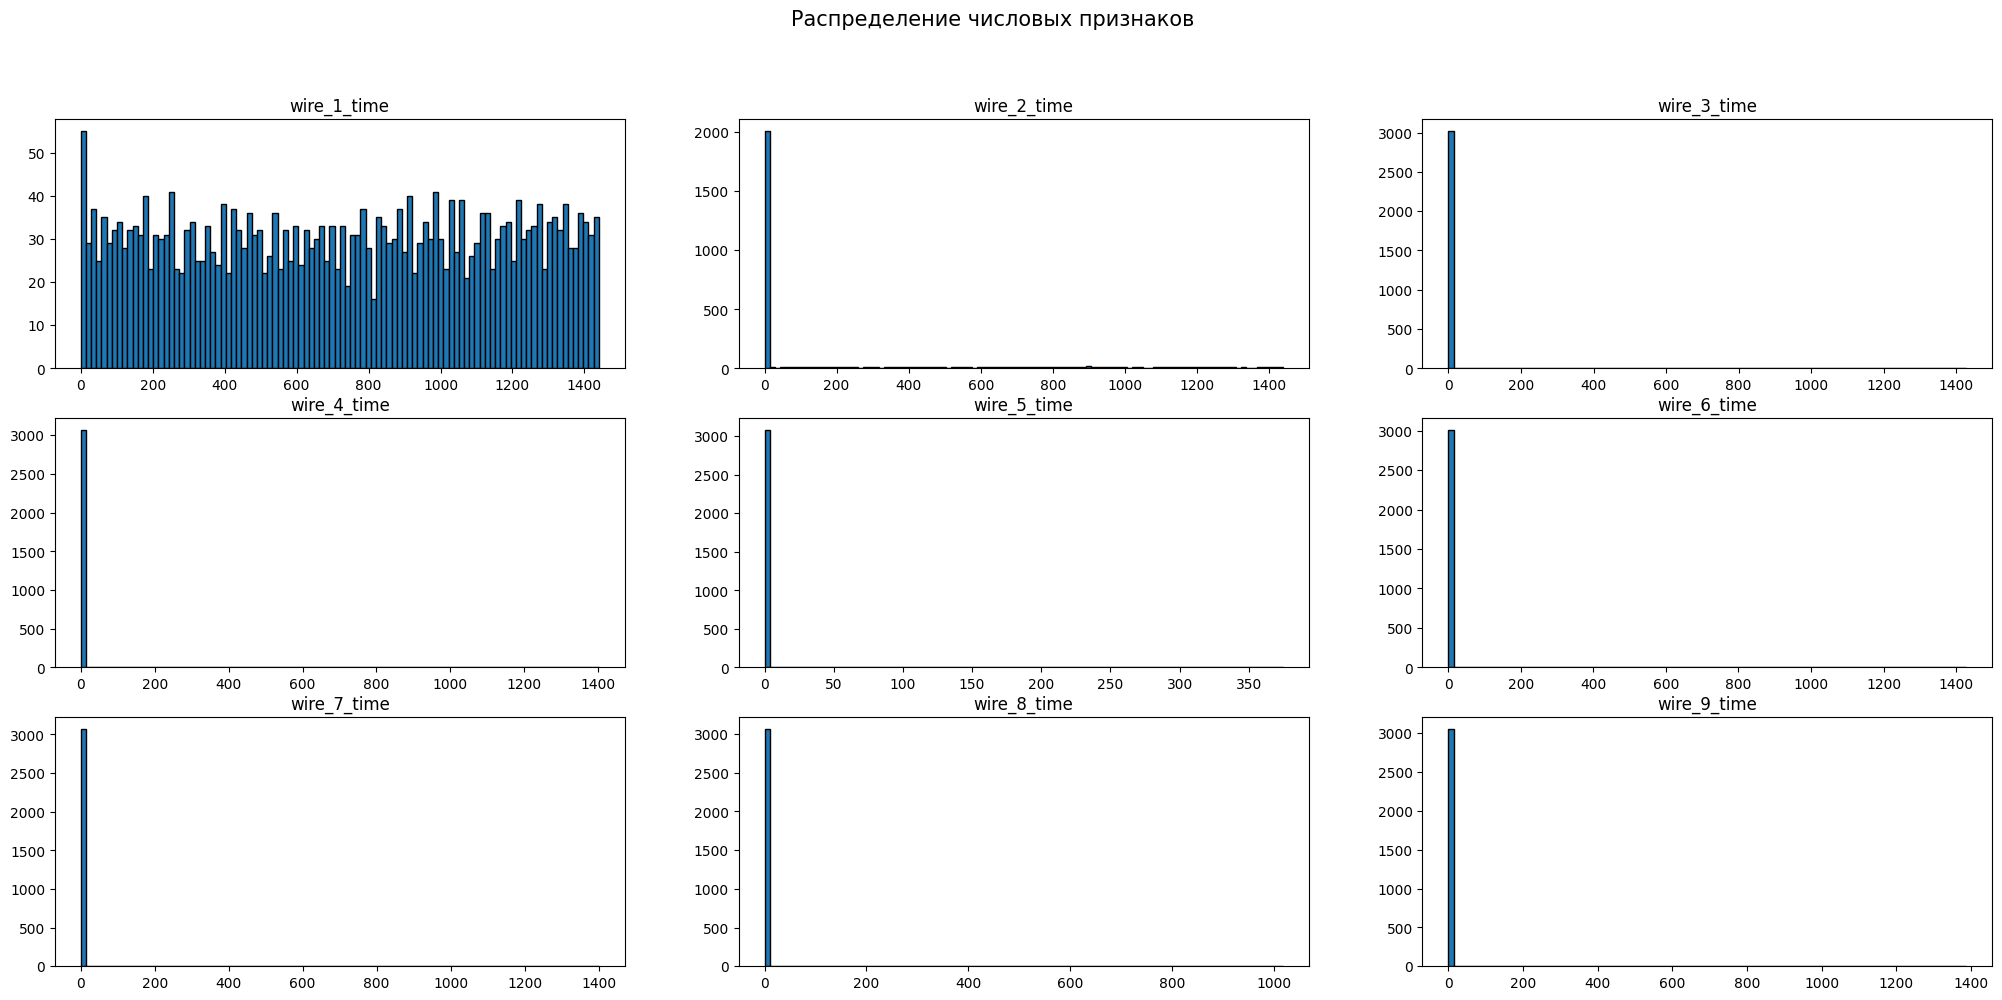

In [121]:
hist_plot(data=df_data_wire_time, num_cols=df_data_wire_time.columns, n=3)

Наличие данных в таблице со временем подачи соответствует наличию факта подачи в предыдущей таблице.

## Объединение таблиц

In [122]:
df_train = df_data_arc.copy()

In [123]:
for data in [df_data_bulk, df_data_bulk_time, df_data_gas, df_data_temp, df_data_wire, df_data_wire_time]:
    df_train = df_train.merge(data, on=['key'], how='inner')

In [124]:
df_train.sample(5, random_state=RANDOM_STATE)

,heat_count,power_active,power_reactive,heat_duration,power_all,consumption,bulk_1,bulk_2,bulk_3,bulk_4,...,wire_9,wire_1_time,wire_2_time,wire_3_time,wire_4_time,wire_5_time,wire_6_time,wire_7_time,wire_8_time,wire_9_time
key,,,,,,,,,,,,,,,,,,,,,
425,7,3.310327,2.531790,1224.0,4.168631,697.831372,0.0,0.0,0.0,105.0,...,0.0,1033.233333,0.00,0.000000,0.0,0.0,0.00,0.00,0.0,0.0
34,3,1.591333,1.155022,717.0,1.969555,504.636265,0.0,0.0,244.0,0.0,...,0.0,891.100000,0.00,0.000000,0.0,0.0,0.00,0.00,0.0,0.0
2565,7,4.408322,3.123997,736.0,5.410297,539.776575,44.0,254.0,0.0,100.0,...,0.0,0.000000,0.00,89.133333,0.0,0.0,77.35,73.75,0.0,0.0
2267,6,3.469218,2.855895,1029.0,4.496424,830.004176,0.0,0.0,111.0,0.0,...,0.0,58.200000,0.00,0.000000,0.0,0.0,0.00,0.00,0.0,0.0
512,6,4.364937,3.127243,1584.0,5.374670,1330.382298,0.0,0.0,62.0,0.0,...,0.0,184.000000,172.95,0.000000,0.0,0.0,0.00,0.00,0.0,0.0


In [125]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3020 entries, 1 to 3241
Data columns (total 58 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   heat_count      3020 non-null   int64  
 1   power_active    3020 non-null   float64
 2   power_reactive  3020 non-null   float64
 3   heat_duration   3020 non-null   float64
 4   power_all       3020 non-null   float64
 5   consumption     3020 non-null   float64
 6   bulk_1          3020 non-null   float64
 7   bulk_2          3020 non-null   float64
 8   bulk_3          3020 non-null   float64
 9   bulk_4          3020 non-null   float64
 10  bulk_5          3020 non-null   float64
 11  bulk_6          3020 non-null   float64
 12  bulk_7          3020 non-null   float64
 13  bulk_8          3020 non-null   float64
 14  bulk_9          3020 non-null   float64
 15  bulk_10         3020 non-null   float64
 16  bulk_11         3020 non-null   float64
 17  bulk_12         3020 non-null   float6

Во втором шаге исследования данных мы очистили таблицы от аномалий и обработали пропуски. В таблице с данными об электродах были созданы новые признаки, и выявлено гамма-распределение данных. В таблицах с добавлением сыпучих и проволочных материалов, где были значительные пропуски, они были заполнены нулями, что отображает случаи их недобавления, а само распределение материалов в обеих таблицах также близко к нулю.

Для таблицы с добавлением газа пропуски также были заполнены нулями, указывая на отсутствие добавления, и установлено, что данные имеют гамма-распределение. В таблице с температурными данными по рекомендации заказчика удалили значения ниже 1500, и данные были нормализованы так, чтобы избежать утечки признаков. В таблице со временем добавления материалов установили совпадение времени и факта добавления как сыпучих, так и проволочных материалов.